# LIB

In [116]:
import os
import sys

sys.path.append('/home/julien/Bureau/Julien/02_DATA_PROJECTS/Maintenance')

import config

import pandas as pd
import numpy as np


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from imblearn.over_sampling import SMOTENC, SMOTE

from lightgbm import LGBMClassifier

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier, lg
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

from src.utils.Functions import get_metrics # fonction pour avoir les metrics de mon modeling

import lazypredict
from lazypredict import LazyClassifier

# EXPLORATION

In [117]:

df = pd.read_csv(os.path.join(config.DATA_DIR, 'maintenance_data.csv'))
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0
1,2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0
2,3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0
3,4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0
4,5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0
9996,9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0
9997,9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0
9998,9999,H39412,H,299.00,308.70,1408,48.50,25,0,0,0,0,0,0


ID : identifiant  
product ID : Low Medium et High quality products  
air temperature  
Temperature d'activité  
Vitesse adtivité  
torque : force de rotation  
tool wear : usure  
Machone et failure et problemes : TWF= tool failure, HDF = heat dissipation, PWF = power failure, OSF = overstain failure, RNF = random failures  

In [118]:
#check duplicates
df_duplicates = df.duplicated().sum()
df_duplicates

0

In [119]:
#check valeurs manquantes
df_isna = df.isna().sum()
df_isna

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [121]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,300.00,310.01,1538.78,39.99,107.95,0.03,0.00,0.01,0.01,0.01,0.00
std,2886.90,2.00,1.48,179.28,9.97,63.65,0.18,0.07,0.11,0.10,0.10,0.04
min,1.00,295.30,305.70,1168.00,3.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2500.75,298.30,308.80,1423.00,33.20,53.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,5000.50,300.10,310.10,1503.00,40.10,108.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,7500.25,301.50,311.10,1612.00,46.80,162.00,0.00,0.00,0.00,0.00,0.00,0.00
max,10000.00,304.50,313.80,2886.00,76.60,253.00,1.00,1.00,1.00,1.00,1.00,1.00


In [122]:
df[df['Machine failure'] == 1]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,51,L47230,L,298.90,309.10,2861,4.60,143,1,0,0,1,0,0
69,70,L47249,L,298.90,309.00,1410,65.70,191,1,0,0,1,1,0
77,78,L47257,L,298.80,308.90,1455,41.30,208,1,1,0,0,0,0
160,161,L47340,L,298.40,308.20,1282,60.70,216,1,0,0,0,1,0
161,162,L47341,L,298.30,308.10,1412,52.30,218,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,9759,L56938,L,298.60,309.80,2271,16.20,218,1,1,0,0,0,0
9764,9765,L56944,L,298.50,309.50,1294,66.70,12,1,0,0,1,0,0
9822,9823,L57002,L,298.50,309.40,1360,60.90,187,1,0,0,0,1,0
9830,9831,L57010,L,298.30,309.30,1337,56.10,206,1,0,0,0,1,0


In [123]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0
1,2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0
2,3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0
3,4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0
4,5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0
9996,9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0
9997,9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0
9998,9999,H39412,H,299.00,308.70,1408,48.50,25,0,0,0,0,0,0


In [124]:
#rename

rename_col = {
    'UID' : 'ID',
    'Product ID' : 'Product_ID',
    'Air temperature [K]' : 'Air_Temperature',
    'Process Temperature [K]' : 'Process_Temperature',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_Wear',
    'Machine failure' : 'Failure'
}

df.rename(rename_col, axis=1, inplace=True)



In [125]:
df

,UDI,Product_ID,Type,Air_Temperature,Process temperature [K],Rotational speed [rpm],Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0
1,2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0
2,3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0
3,4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0
4,5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0
9996,9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0
9997,9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0
9998,9999,H39412,H,299.00,308.70,1408,48.50,25,0,0,0,0,0,0


In [126]:
df.set_index('UDI', inplace=True)

In [127]:
df

,Product_ID,Type,Air_Temperature,Process temperature [K],Rotational speed [rpm],Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0
2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0
3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0
4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0
5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0
9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0
9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0


In [128]:
failures_sum = df.Failure.value_counts()
print('il y a',failures_sum[1], 'problemes')



il y a 339 problemes


In [129]:
df.describe()

,Air_Temperature,Process temperature [K],Rotational speed [rpm],Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,300.00,310.01,1538.78,39.99,107.95,0.03,0.00,0.01,0.01,0.01,0.00
std,2.00,1.48,179.28,9.97,63.65,0.18,0.07,0.11,0.10,0.10,0.04
min,295.30,305.70,1168.00,3.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,298.30,308.80,1423.00,33.20,53.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,300.10,310.10,1503.00,40.10,108.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,301.50,311.10,1612.00,46.80,162.00,0.00,0.00,0.00,0.00,0.00,0.00
max,304.50,313.80,2886.00,76.60,253.00,1.00,1.00,1.00,1.00,1.00,1.00


In [130]:
# defintion de fonction pour avoir une colonne Failure_type en fonction des valeurs du dataset

def failure_type(row):
    if row['Failure'] == 0:
        return 'No_failure'
    else:
        max_value = max(row[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']])
        if max_value == row['TWF']:
            return 'TWF'
        elif max_value == row['HDF']:
            return 'HDF'
        elif max_value == row['PWF']:
            return 'PWF'
        elif max_value == row['OSF']:
            return 'OSF'
        else:
            return 'RNF'
        
df['Failure_type'] = df.apply(failure_type, axis=1)

df

,Product_ID,Type,Air_Temperature,Process temperature [K],Rotational speed [rpm],Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0,No_failure


In [131]:
import pandas as pd

#renaming
dic_rename = {
    'Process temperature [K]': 'Process_temperature',
    'Rotational speed [rpm]': 'Rotational_speed'
}


df.rename(columns=dic_rename, inplace=True)




In [132]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [133]:
df

,Product_ID,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0,No_failure


# DATAVIZ

In [134]:
# Class distribution
count_quality = df['Type'].value_counts()
fig = px.bar(x=count_quality.index, y=count_quality.values, color=count_quality.index)
fig.update_layout(title='Distribution des classes', xaxis_title='Type', yaxis_title='Nombre')
fig.show()


Bad class distribution, too much low quality gear

In [135]:
import plotly.express as px

# Types de problemes
count_failures = df['Failure_type'].value_counts()

# Calculer les pourcentages
pourcentages = count_failures / count_failures.sum() * 100

# Créer le graphique à barres avec Plotly Express
fig = px.bar(x=count_failures.index, y=count_failures.values, color=count_failures.index, text=pourcentages.round(2).astype(str) + '%')

# Mettre à jour les paramètres de la figure
fig.update_layout(title='Types de problèmes', xaxis_title='Type', yaxis_title='Occurences')

# Afficher les pourcentages au-dessus des barres
fig.update_traces(textposition='outside')

# Afficher la figure
fig.show()


Bad class distribution of failures, as the plot shows, there is too much 'no failure', it will be a problem further

To conclude, we got a bad distribution and a multi target class

In [136]:
df

,Product_ID,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0,No_failure


In [137]:

df_failure_type = df.loc[df['Failure_type'] != "No Failure"]
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)

plt.figure(figsize=(5, 8))
fig = px.pie(proportions, values=proportions.values, names=proportions.index, title='Class Distribution')
fig.show()


<Figure size 500x800 with 0 Axes>

In [138]:
df

,Product_ID,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0,No_failure


In [139]:
import plotly.graph_objects as go

numeric_values = df[['Air_Temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_Wear']]
# Calculate correlation matrix
corr = numeric_values.corr()

plt.figure(figsize=(10, 8))

# Create heatmap trace
heatmap_trace = go.Heatmap(z=corr.values,
                           x=corr.columns,
                           y=corr.columns,
                           colorscale='RdBu',
                           zmin=-1, zmax=1)

# Define layout
layout = go.Layout(title='Correlation of Numeric Values',
                   xaxis=dict(title='Features'),
                   yaxis=dict(title='Features'))

# Create figure
fig = go.Figure(data=[heatmap_trace], layout=layout)

# Show figure
fig.show()



<Figure size 1000x800 with 0 Axes>

#### Air_temp - Process_temp  
#### Torque - Rotational_speed negative corr

## CLEANNING  
ajustement des valeurs sur l ensemble des colonnes numeriques


In [140]:
df

,Product_ID,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.10,308.60,1551,42.80,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.20,308.70,1408,46.30,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.10,308.50,1498,49.40,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.20,308.60,1433,39.50,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.20,308.70,1408,40.00,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.80,308.40,1604,29.50,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.90,308.40,1632,31.80,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.00,308.60,1645,33.40,22,0,0,0,0,0,0,No_failure


In [141]:
columns_to_drop = ['Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Product_ID']
df.drop(columns=columns_to_drop, inplace=True, axis=1)


In [142]:
df

,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure_type
UDI,,,,,,,
1,M,298.10,308.60,1551,42.80,0,No_failure
2,L,298.20,308.70,1408,46.30,3,No_failure
3,L,298.10,308.50,1498,49.40,5,No_failure
4,L,298.20,308.60,1433,39.50,7,No_failure
5,L,298.20,308.70,1408,40.00,9,No_failure
...,...,...,...,...,...,...,...
9996,M,298.80,308.40,1604,29.50,14,No_failure
9997,H,298.90,308.40,1632,31.80,17,No_failure
9998,M,299.00,308.60,1645,33.40,22,No_failure


In [143]:
# Pipeline

#Definition des col num et cat
num_col = ['Air_Temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_Wear']
cat_col = ['Type', 'Failure_type']

# Standard scale pour numeric et one hot pour categories
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])
# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, num_col),
    ('cat_trans', cat_pipeline, cat_col)
])
# Entrainement sur les data preprocessor
df_transformed = preprocessor.fit_transform(df)


# Nouveau noms pour les colonnes one hot
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(cat_col)
new_column_names = list(num_col) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()

,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Type_H,Type_L,Type_M,Failure_type_HDF,Failure_type_No_failure,Failure_type_OSF,Failure_type_PWF,Failure_type_TWF
0,-0.95,-0.95,0.07,0.28,-1.70,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
1,-0.90,-0.88,-0.73,0.63,-1.65,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
2,-0.95,-1.01,-0.23,0.94,-1.62,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
3,-0.90,-0.95,-0.59,-0.05,-1.59,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
4,-0.90,-0.88,-0.73,0.00,-1.55,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00


##

# DIM_REDUCTION : PCA_test
### before the SMOTE

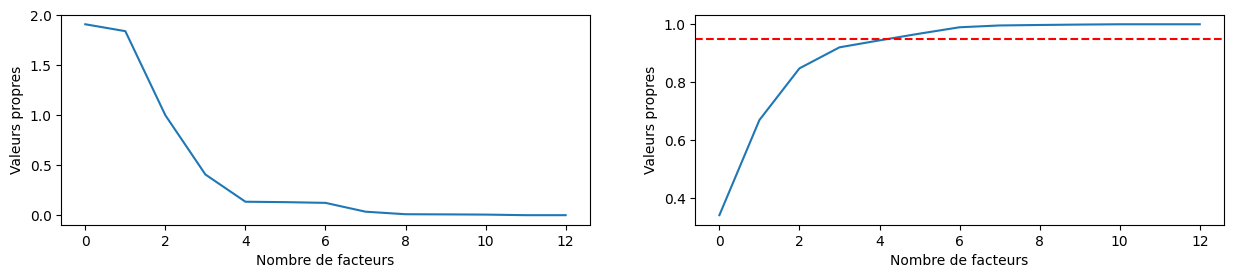

In [144]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_transformed)

plt.figure(figsize=(15, 6))

plt.subplot(2,2,1)
plt.plot(range(0,13), pca.explained_variance_)
plt.xlabel('Nombre de facteurs')
plt.ylabel('Valeurs propres')

plt.subplot(2,2,2)
plt.plot(range(0,13), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de facteurs')
plt.ylabel('Valeurs propres')
plt.axhline(y=0.95, color = 'r', linestyle = '--')

In [145]:
pca = PCA(n_components=0.95)
pca.fit(df_transformed)
print('number of usefull component', pca.n_components_)

number of usefull component 6


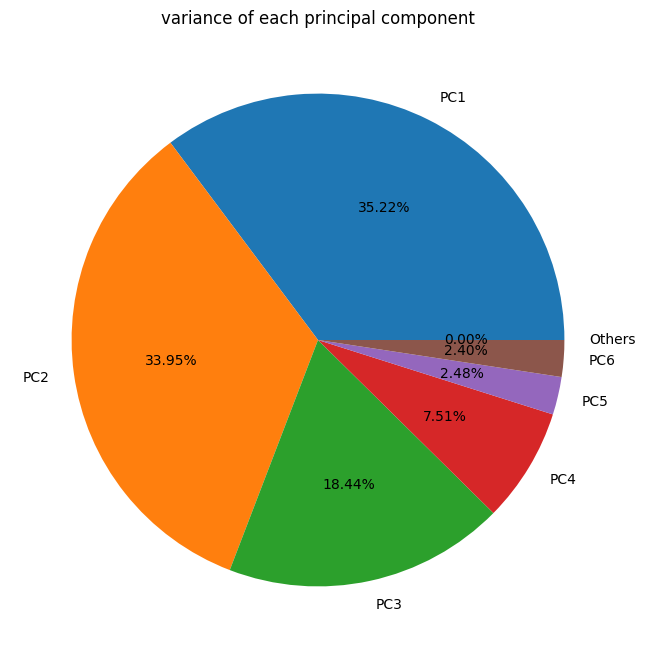

In [146]:
L1 = list(pca.explained_variance_ratio_[0:7])
L1.append(sum(pca.explained_variance_ratio_[7:14]))

plt.figure(figsize=(10, 8))
plt.pie(L1, labels=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'Others'], 
        autopct='%1.2f%%')

plt.title("variance of each principal component")
plt.show()

In [147]:
df_transformed

,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Type_H,Type_L,Type_M,Failure_type_HDF,Failure_type_No_failure,Failure_type_OSF,Failure_type_PWF,Failure_type_TWF
0,-0.95,-0.95,0.07,0.28,-1.70,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
1,-0.90,-0.88,-0.73,0.63,-1.65,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
2,-0.95,-1.01,-0.23,0.94,-1.62,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
3,-0.90,-0.95,-0.59,-0.05,-1.59,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
4,-0.90,-0.88,-0.73,0.00,-1.55,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.60,-1.08,0.36,-1.05,-1.48,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9996,-0.55,-1.08,0.52,-0.82,-1.43,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
9997,-0.50,-0.95,0.59,-0.66,-1.35,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9998,-0.50,-0.88,-0.73,0.85,-1.30,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [148]:
df_modeling = df.copy()

In [149]:
df_modeling

,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure_type
UDI,,,,,,,
1,M,298.10,308.60,1551,42.80,0,No_failure
2,L,298.20,308.70,1408,46.30,3,No_failure
3,L,298.10,308.50,1498,49.40,5,No_failure
4,L,298.20,308.60,1433,39.50,7,No_failure
5,L,298.20,308.70,1408,40.00,9,No_failure
...,...,...,...,...,...,...,...
9996,M,298.80,308.40,1604,29.50,14,No_failure
9997,H,298.90,308.40,1632,31.80,17,No_failure
9998,M,299.00,308.60,1645,33.40,22,No_failure


# 1st MODELING STEP
### LAZY_PRED

to quicly find the best algorithm

In [150]:
from imblearn.over_sampling import SMOTE
from lazypredict import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd


In [151]:
# split 'Type' into in columns
df_modeling_updated = pd.get_dummies(df_modeling, columns=['Type'], dtype=int)
df_modeling_updated

,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure_type,Type_H,Type_L,Type_M
UDI,,,,,,,,,
1,298.10,308.60,1551,42.80,0,No_failure,0,0,1
2,298.20,308.70,1408,46.30,3,No_failure,0,1,0
3,298.10,308.50,1498,49.40,5,No_failure,0,1,0
4,298.20,308.60,1433,39.50,7,No_failure,0,1,0
5,298.20,308.70,1408,40.00,9,No_failure,0,1,0
...,...,...,...,...,...,...,...,...,...
9996,298.80,308.40,1604,29.50,14,No_failure,0,0,1
9997,298.90,308.40,1632,31.80,17,No_failure,1,0,0
9998,299.00,308.60,1645,33.40,22,No_failure,0,0,1


In [152]:
# Define Features and  Target (X and y)
X = df_modeling_updated.drop('Failure_type', axis=1)
y = df_modeling_updated['Failure_type']

# Split train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## BALANCED CLASS : SMOTE
may i need to use pca + smote

In [153]:
# SMOTE to get balanced class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


## LAZY PRED

In [154]:
lzy_clf = LazyClassifier(predictions=True)


In [155]:
models, predictions = lzy_clf.fit(X_train_resampled, X_test, y_train_resampled, y_test)
models

 90%|████████▉ | 26/29 [02:27<00:12,  4.21s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 38645, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


100%|██████████| 29/29 [02:28<00:00,  5.10s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.88,0.89,None,0.92,0.32
SGDClassifier,0.85,0.88,None,0.90,0.19
CalibratedClassifierCV,0.88,0.85,None,0.92,0.84
LinearSVC,0.87,0.85,None,0.91,1.84
SVC,0.91,0.82,None,0.94,5.60
RidgeClassifierCV,0.79,0.80,None,0.86,0.11
RidgeClassifier,0.79,0.80,None,0.86,0.08
LinearDiscriminantAnalysis,0.75,0.80,None,0.84,0.08
Perceptron,0.75,0.78,None,0.84,0.12


In [156]:
models.sort_values(['Balanced Accuracy','F1 Score','Time Taken'], ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.88,0.89,None,0.92,0.32
SGDClassifier,0.85,0.88,None,0.90,0.19
CalibratedClassifierCV,0.88,0.85,None,0.92,0.84
LinearSVC,0.87,0.85,None,0.91,1.84
SVC,0.91,0.82,None,0.94,5.60
RidgeClassifierCV,0.79,0.80,None,0.86,0.11
RidgeClassifier,0.79,0.80,None,0.86,0.08
LinearDiscriminantAnalysis,0.75,0.80,None,0.84,0.08
Perceptron,0.75,0.78,None,0.84,0.12


So, **SVC** is the best but compared with the time taken, we can use **Logistic Regression** if compute time is important

# 2nd MODELING STEP
### LOGISTIC REG / SVC and RANDOM FOREST

In [157]:
# encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)

### Logistic Regression

In [158]:
lr = LogisticRegressionCV(multi_class='multinomial',solver='lbfgs', cv=StratifiedKFold(n_splits=5))
lr.fit(X_train_resampled, y_train_encoded)

y_pred_lr = lr.predict(X_test)
f1_lr = f1_score(y_test_encoded, y_pred_lr, average='weighted')
print("F1 score:", f1)

predictions_lr = label_encoder.inverse_transform(y_pred_lr)
print(classification_report(y_test_encoded, predictions))

F1 score: 0.8064162943478412


ValueError: Classification metrics can't handle a mix of multiclass and multiclass-multioutput targets

### SVC

In [ ]:
svc = SVC(kernel='rbf', class_weight='balanced')
svc.fit(X_train_resampled, y_train_encoded)

y_pred_svc = svc.predict(X_test)

f1_svc = f1_score(y_test_encoded, y_pred_svc, average='weighted')
print("F1 score:", f1_svc)

predictions_svc = label_encoder.inverse_transform(y_pred_svc)
print(classification_report(y_test_encoded, predictions_svc))

F1 score: 0.7873782617730284
              precision    recall  f1-score   support

         HDF       0.07      0.83      0.13        23
  No_failure       1.00      0.68      0.81      1932
         OSF       0.21      0.94      0.34        16
         PWF       0.47      0.50      0.49        18
         TWF       0.03      0.73      0.05        11

    accuracy                           0.68      2000
   macro avg       0.35      0.73      0.36      2000
weighted avg       0.97      0.68      0.79      2000



### LGBMClassifier

In [169]:
lgbmc_clf = LGBMClassifier(class_weight='balanced',num_leaves=31, n_estimators=100, objective='multiclass', random_state=42)
lgbmc_clf.fit(X_train_resampled, y_train_encoded)

# Prédire sur les données de test
y_pred_lgbmc = lgbmc_clf.predict(X_test)

# Calculer les métriques
print(classification_report(y_test_encoded, y_pred_lgbmc))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 38645, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       0.99      0.98      0.99      1932
           2       0.73      1.00      0.84        16
           3       0.80      0.89      0.84        18
           4       0.08      0.18      0.11        11

    accuracy                           0.98      200

### RANDOM FOREST

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train_resampled, y_train_encoded)

y_pred_rfc = rfc.predict(X_test)

f1_rfc = f1_score(y_test_encoded, y_pred_rfc, average='weighted')
print("F1 score:", f1_rfc)

predictions_rfc = label_encoder.inverse_transform(y_pred_rfc)
print(classification_report(y_test_encoded, predictions_rfc))

F1 score: 0.9713548747737648
              precision    recall  f1-score   support

         HDF       0.68      0.74      0.71        23
  No_failure       0.99      0.98      0.98      1932
         OSF       0.67      0.88      0.76        16
         PWF       0.71      0.83      0.77        18
         TWF       0.04      0.09      0.06        11

    accuracy                           0.97      2000
   macro avg       0.62      0.70      0.66      2000
weighted avg       0.98      0.97      0.97      2000



## GRIDSEARCH BEST PARAMETERS


In [174]:
# LGBMC

param_lgbmc = {
    'n_estimators': [100],     # Nombre d'arbres
    #'max_depth': [None, 10, 20, 30],      # Profondeur maximale de l'arbre
    'num_leaves': [20, 60, 100],          # Nombre maximum de feuilles dans un arbre
    #'min_child_samples': [20, 50, 100],   # Nombre minimal d'échantillons dans une feuille
    'learning_rate': [0.1],   # Taux d'apprentissage
    #'subsample': [0.8, 1.0],         # Sous-échantillonnage de la formation des données
    #'colsample_bytree': [0.8, 1.0],   # Fraction de caractéristiques à utiliser pour la construction de chaque arbre
    'class_weight': ['balanced']# Poids de classe
}

lgbmc_model = LGBMClassifier(random_state=42, force_col_wise=True)

grid_search_lgbmc = GridSearchCV(estimator=lgbmc_model, param_grid=param_lgbmc, 
                                 cv=5, scoring='f1_weighted', n_jobs=-1)

grid_search_lgbmc.fit(X_train_resampled, y_train_encoded)

print("Meilleurs paramètres:", grid_search_lgbmc.best_params_)
print("Meilleur score (F1 weighted):", grid_search_lgbmc.best_score_)


[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 30916, number of used features: 8
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Number of data points in the train set: 30916, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 30916, number of used features: 8
[LightGBM] [Info] Total Bins 1280[LightGBM] [Info] Start training from score -1.60

In [179]:
# get personnal metrics

lgbmc_tuned_model = grid_search_lgbmc.best_estimator_
y_pred_lgbmc_tuned = lgbmc_tuned_model.predict(X_test)
get_metrics(y_test_encoded, y_pred_lgbmc_tuned)

{'Accuracy': 0.9785,
 'Recall': 0.7660800552104899,
 'Precision': 0.6874308850509268,
 'F1': 0.7218931956333972,
 'F1 Scores per Class': array([0.93617021, 0.98908524, 0.84210526, 0.84210526, 0.        ])}

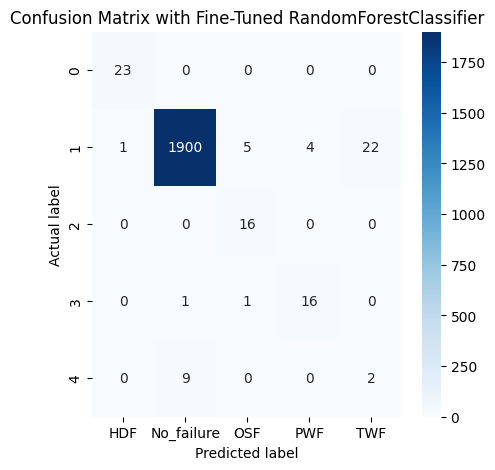

In [180]:
#conf matrix

cm = confusion_matrix(y_test_encoded, y_pred_lgbmc)

plt.figure(figsize=(5, 5)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_pred_lgbmc))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned RandomForestClassifier')
plt.show()

# EXPORT

In [183]:
# model export
import joblib

joblib.dump(lgbmc_tuned_model, '../model/lgbmc_model.joblib')

['../model/lgbmc_model.joblib']